## Importing libraries

In [ ]:
!pip install category_encoders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from datetime import*
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from geopy.geocoders import Nominatim
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 8.0 MB/s eta 0:00:00


# Modelling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
sales = pd.read_csv('/content/drive/Shareddrives/Capstone/CAPSTONE MODEL/preprocessed_data.csv').drop('Unnamed: 0', axis=1)

Mounted at /content/drive


In [ ]:
sales

COD_ARTICULO  COD_LOCALIZACION  UDS_VENDIDAS_TOTAL  \
0              52308               673                  41   
1              50785               662                   8   
2              33542                33                  10   
3              19299               431                   3   
4              25953               431                   3   
...              ...               ...                 ...   
201402         56056                33                  21   
201403         56073                33                  27   
201404         56841                33                  36   
201405         56845                33                  53   
201406         58176                33                   8   

       FECHA_PRIMERA_VENTA  DIAS_HASTA_SALDO  FACTURADO         MERCADO  \
0               2018-01-12               207         42           SPAIN   
1               2018-01-12               207         10  UNITED KINGDOM   
2               2018-01-12               209         15           SPAIN   
3               2018-01-12               201         30           SPAIN   
4               2018-01-12               201         34           SPAIN   
...                    ...               ...        ...             ...   
201402          2022-09-05                44         29           SPAIN   
201403          2022-09-05                44         37           SPAIN   
201404          2022-09-05                44         56           SPAIN   
201405          2022-09-05                44         75           SPAIN   
201406          2022-09-05                44         37           SPAIN   

        LATITUD  LONGITUD COD_TIPO_LOCALIZACION  ...  month3 month4  month5  \
0       37.1463   -3.6127                  T4-7  ...       1      1       1   
1       51.5162   -0.1329                  T4-7  ...       1      1       1   
2       40.4267   -3.6756                    T5  ...       1      1       1   
3       42.2215   -8.7237                    T5  ...       1      1       1   
4       42.2215   -8.7237                    T5  ...       1      1       1   
...         ...       ...                   ...  ...     ...    ...     ...   
201402  40.4267   -3.6756                    T5  ...       0      0       0   
201403  40.4267   -3.6756                    T5  ...       0      0       0   
201404  40.4267   -3.6756                    T5  ...       0      0       0   
201405  40.4267   -3.6756                    T5  ...       0      0       0   
201406  40.4267   -3.6756                    T5  ...       0      0       0   

        month6  month7  month8  month9  month10  month11  month12  
0            1       1       1       0        0        0        0  
1            1       1       1       0        0        0        0  
2            1       1       1       0        0        0        0  
3            1       1       1       0        0        0        0  
4            1       1       1       0        0        0        0  
...        ...     ...     ...     ...      ...      ...      ...  
201402       0       0       0       1        1        0        0  
201403       0       0       0       1        1        0        0  
201404       0       0       0       1        1        0        0  
201405       0       0       0       1        1        0        0  
201406       0       0       0       1        1        0        0  

[201407 rows x 64 columns]

In [ ]:
df_train = sales

Text(0.5, 1.0, 'Number of campaigns for each campaign length')

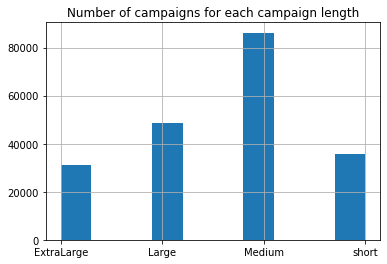

In [ ]:
# Creating column that labels DIAS_HASTA_SALDO based on the length of each campaign
bins = [0, 60, 120, 160, 250]
labels = ['short', 'Medium', 'Large', 'ExtraLarge']
df_train['Campaign_length'] = pd.cut(df_train['DIAS_HASTA_SALDO'], bins=bins, labels=labels)
df_train['Campaign_length'].hist()
mapping = {'ExtraLarge':4, 'Large':3, 'Medium':2, 'short':1}
df_train['Campaign_length'] = df_train['Campaign_length'].map(mapping)
plt.title('Number of campaigns for each campaign length')

In [ ]:
## Changing DataTypes previous to model
df_train['COD_SUBTIPO']= df_train['COD_SUBTIPO'].astype(str)
df_train['city'] = df_train['city'].astype(str)
df_train['COD_ARTICULO']= df_train['COD_ARTICULO'].astype(str)
df_train['MERCADO']= df_train['MERCADO'].astype(str)
df_train['COD_COMPRADOR']= df_train['COD_COMPRADOR'].astype(str)
df_train['COD_TIPO_LOCALIZACION']= df_train['COD_TIPO_LOCALIZACION'].astype(str)
df_train['COD_LOCALIZACION']=df_train['COD_LOCALIZACION'].astype(str)
df_train['COD_COLOR']=df_train['COD_COLOR'].astype(str)
df_train['COD_TIPO']= df_train['COD_TIPO'].astype(str)
df_train.drop(['FECHA_PRIMERA_VENTA', 'LATITUD', 'LONGITUD', 'end_date', 'day_of_week', 'weekend','month', 'end_month'], axis=1, inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201407 entries, 0 to 201406
Data columns (total 57 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   COD_ARTICULO            201407 non-null  object  
 1   COD_LOCALIZACION        201407 non-null  object  
 2   UDS_VENDIDAS_TOTAL      201407 non-null  int64   
 3   DIAS_HASTA_SALDO        201407 non-null  int64   
 4   FACTURADO               201407 non-null  int64   
 5   MERCADO                 201407 non-null  object  
 6   COD_TIPO_LOCALIZACION   201407 non-null  object  
 7   COD_COMPRADOR           201407 non-null  object  
 8   COD_TIPO                201407 non-null  object  
 9   COD_SUBTIPO             201407 non-null  object  
 10  UDS_COMPRADAS           201407 non-null  int64   
 11  PRECIO                  201407 non-null  float64 
 12  COD_COLOR               201407 non-null  object  
 13  year                    201407 non-null  int64   
 14  week

In [ ]:
train_df = df_train

In [ ]:
## Baseline performance
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

## Define Train Test Datasets
X = train_df.drop("UDS_VENDIDAS_TOTAL", axis=1) 
y = train_df["UDS_VENDIDAS_TOTAL"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, shuffle=True,test_size=0.1)

## Model 1: XGBoost with Facturado

In [ ]:
##Feature names that will be transformed with target encoding
target_encoding_cats=['COD_LOCALIZACION','COD_SUBTIPO', 'city','COD_ARTICULO', 'COD_COLOR']

##Feature names that will be transformed with one-hot encoding
ohe_variables = ['MERCADO','COD_COMPRADOR','COD_TIPO_LOCALIZACION','COD_TIPO', 'year']

#Defining transformer
transformer = ColumnTransformer(transformers=[
    ('TAR',TargetEncoder(),target_encoding_cats),
    ('OHE',OneHotEncoder(), ohe_variables)],
     remainder='passthrough')

#calling the transformer for both train/test sets
X_train_transformed=transformer.fit_transform(X_train,y_train)
X_test_transformed=transformer.transform(X_test)



In [ ]:
xg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.3, max_depth = 7,
                      eval_metric='rmse', reg_alpha= 94.0,
                      reg_lambda= 0.865038587726904, gamma = 3.628 )
xg.fit(X_train_transformed, y_train)

[14:26:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(eval_metric='rmse', gamma=3.628, learning_rate=0.3, max_depth=7,
             n_estimators=1000, reg_alpha=94.0, reg_lambda=0.865038587726904)

In [ ]:
# Boosting score for training dataset
print(xg.score(X_train_transformed, y_train))
# Boosting score for test dataset
print(xg.score(X_test_transformed, y_test))


0.9587527885100189
0.8635768774114644


In [ ]:
y_train_est_xg = xg.predict(X_train_transformed)
y_test_est_xg  = xg.predict(X_test_transformed)

In [ ]:
from sklearn import metrics
print(metrics.mean_absolute_error(y_train,y_train_est_xg))
print(metrics.mean_absolute_error(y_test,y_test_est_xg))


2.284731411716579
3.7915582888549326


In [ ]:
from sklearn import metrics
#MSE score for both training and test dataset
print(metrics.mean_squared_error(y_train,y_train_est_xg))
print(metrics.mean_squared_error(y_test,y_test_est_xg))

9.286779907033127
30.23623377628139


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.8/dist-packages/category_encoders/utils.py:360: FutureWarning:

`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.



<AxesSubplot:title={'center':'Model 1: Feature Importance'}>

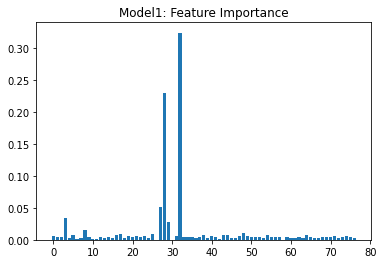

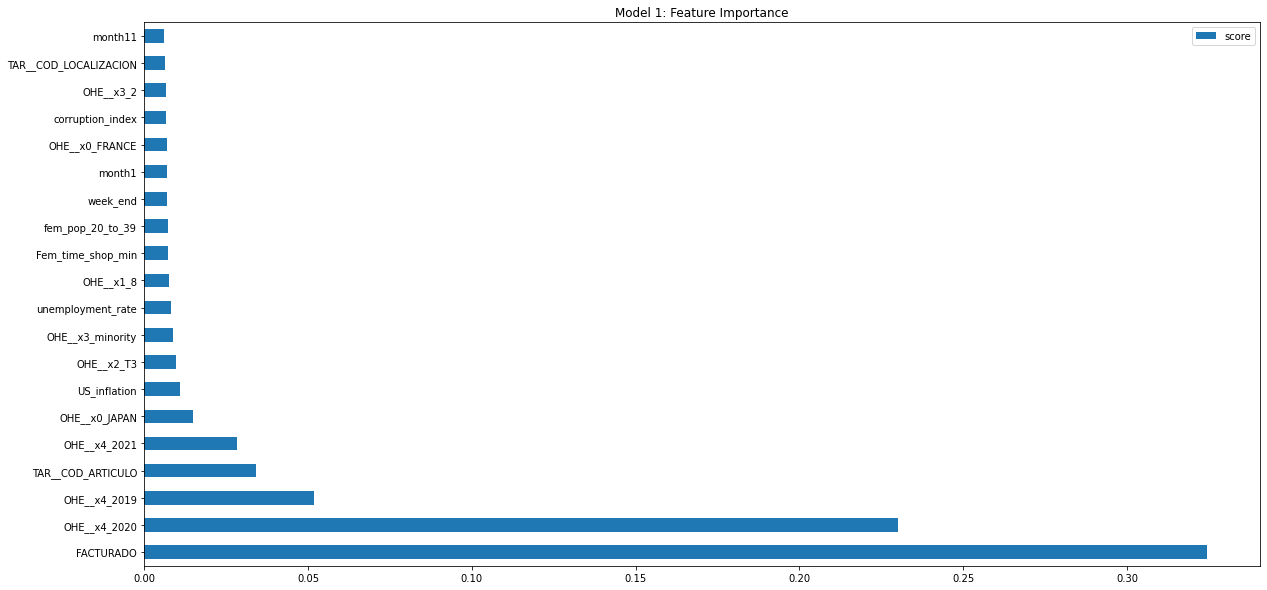

In [ ]:
xg.get_booster().feature_names
plt.bar(range(len(xg.feature_importances_)), xg.feature_importances_)
plt.title('Model1: Feature Importance')

keys = list(transformer.get_feature_names())
values = list(xg.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10), title='Model 1: Feature Importance') ## plot top 40 features

## Model 2: XGBoost without Facturado

In [ ]:
## Define Train Test Datasets
X = train_df.drop(["UDS_VENDIDAS_TOTAL", 'FACTURADO'], axis=1) 
y = train_df["UDS_VENDIDAS_TOTAL"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, shuffle=True,test_size=0.1)

In [ ]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

target_encoding_cats=['COD_LOCALIZACION','COD_SUBTIPO', 'city','COD_ARTICULO', 'COD_COLOR']
ohe_variables = ['MERCADO','COD_COMPRADOR','COD_TIPO_LOCALIZACION','COD_TIPO', 'year']

transformer = ColumnTransformer(transformers=[
    ('TAR',TargetEncoder(),target_encoding_cats),
    ('OHE',OneHotEncoder(), ohe_variables)],
     remainder='passthrough')

X_train_transformed=transformer.fit_transform(X_train,y_train)
X_test_transformed=transformer.transform(X_test)



In [ ]:
xg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.3, max_depth = 7,
                      eval_metric='rmse', reg_alpha= 94.0,
                      reg_lambda= 0.865038587726904, gamma = 3.628 )
xg.fit(X_train_transformed, y_train)

[14:44:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(eval_metric='rmse', gamma=3.628, learning_rate=0.3, max_depth=7,
             n_estimators=1000, reg_alpha=94.0, reg_lambda=0.865038587726904)

In [ ]:
# Boosting score for training dataset
print(xg.score(X_train_transformed, y_train))
# Boosting score for test dataset
print(xg.score(X_test_transformed, y_test))


0.861669772877279
0.4197738405758784


In [ ]:
y_train_est_xg = xg.predict(X_train_transformed)
y_test_est_xg  = xg.predict(X_test_transformed)

In [ ]:
from sklearn import metrics
print(metrics.mean_absolute_error(y_train,y_train_est_xg))
print(metrics.mean_absolute_error(y_test,y_test_est_xg))


3.840743381456842
6.987377254648695


In [ ]:
from sklearn import metrics
#MAE score for both training and test dataset
print(metrics.mean_squared_error(y_train,y_train_est_xg))
print(metrics.mean_squared_error(y_test,y_test_est_xg))

31.144950831176878
128.59882889776316


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.8/dist-packages/category_encoders/utils.py:360: FutureWarning:

`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.



<AxesSubplot:title={'center':'Model 2: Feature Importance'}>

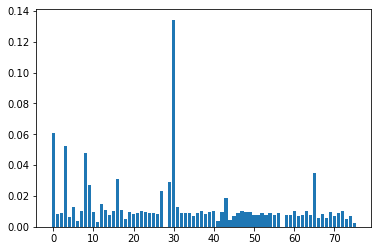

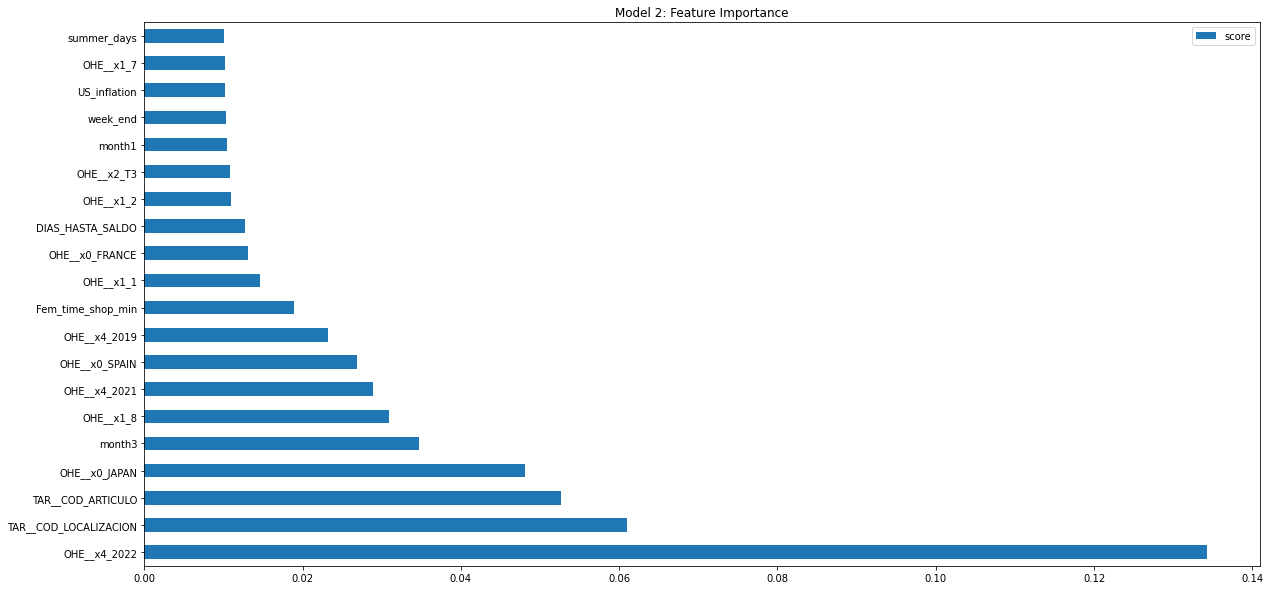

In [ ]:
xg.get_booster().feature_names
plt.bar(range(len(xg.feature_importances_)), xg.feature_importances_)

keys = list(transformer.get_feature_names())
values = list(xg.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10), title='Model 2: Feature Importance') ## plot top 40 features

## Code for Saving/Loading Trained Model

In [ ]:
## SAVING TRAINED MODEL

#import pickle
# Save the trained model as a pickle string.
#saved_model = pickle.dumps(xg)
  
# Load the pickled model
#xg_saved = pickle.loads(saved_model)
  
# Use the loaded pickled model to make predictions
#xg_saved.predict(X_test)

In [ ]:
#import joblib
  
#joblib.dump(xg, 'capstone_model.pkl')
  
# Load the model from the file
#xg_from_joblib = joblib.load('capstone_model.pkl')
  
# Use the loaded model to make predictions
#xg_from_joblib.predict(X_test)

## Hyperparameter Tuning Code


In [ ]:
'''from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

# A parameter grid for XGBoost
params = {
    'n_estimators': [900, 1100],
    'max_depth': [5, 10],
    'learning_rate': [ 0.1, 0.2],
    'min_child_weight': [2, 3]}

xg = xgb.XGBRegressor(nthread=-1)

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(xg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error', verbose=5)

start = time.time()
random_search.fit(X_train_transformed, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
      
best_regressor = random_search.best_estimator_
best_regressor'''